## Setup

Necessary imports, variable and function definitions.

__Notes:__ 
1. Execution of the sequence-based part of this notebook requires a very large amount of disk space (>1TB).
2. **This is merely a demonstration of what sort of analysis could be performed with data fetched using q2-fondue. It does not control for study covariates and should not be replicated directly in a proper meta-analysis.**
3. If you are viewing this notebook directly on GitHub, you will not be able to see the QIIME 2 visualization outputs. You can, however, find all the visualizations in the `u3-metagenome-results` directory and view those on [view.qiime2.org](view.qiime2.org).

In [1]:
import os

import matplotlib.pyplot as plt
import skbio
import pandas as pd
import qiime2 as q2
import seaborn as sns

from qiime2.plugins import (
    fondue, coordinates, demux, sourmash, 
    cutadapt, diversity, emperor
)

%matplotlib inline

results_path = 'u3-metagenome-results'
if not os.path.isdir(results_path):
    os.mkdir(results_path)

In [2]:
email = 'your@email.com'
n_jobs = 8
random_seed = 1

marine_meta_path = os.path.join(results_path, 'tara_metadata.tsv')
marine_meta_clean_path = os.path.join(results_path, 'tara_metadata_clean.tsv')

In [3]:
def clean_up_column(df, col, max_value):
    """
    Cleans up specified DataFrame column by converting it
    to a numeric type and removing values beyond the
    indicated maximum.
    """
    if isinstance(df.iloc[0][col], str):
        df = df[~marine_meta_df[col].str.contains('-')]
    df[col] = pd.to_numeric(df[col])
    df = df[df[col] < max_value]
    return df

## Fetch TARA Oceans shotgun metagenome metadata

We will fetch metadata for all the **shotgun sequencing experiments** for size fractionated samples taken all over the world (including the Polar Circle). For overview of BioProject IDs see the [respective entry on ENA](https://www.ebi.ac.uk/ena/browser/view/PRJEB402).

In [4]:
ids = ['PRJEB1787', 'PRJEB4352', 'PRJEB4419', 'PRJEB9691', 'PRJEB9740', 'PRJEB9742']
ids = pd.Series(ids, name='ID')
ids = q2.Artifact.import_data('NCBIAccessionIDs', ids)

In [5]:
if not os.path.isfile(marine_meta_path):
    marine_meta, _,  = fondue.methods.get_metadata(
        accession_ids=ids,
        email=email,
        n_jobs=n_jobs,
        log_level='WARNING'
    )
    marine_meta_df = marine_meta.view(pd.DataFrame)
    marine_meta_df.to_csv(marine_meta_path, sep='\t', header=True, index=True)
else:
    marine_meta_df = pd.read_csv(marine_meta_path, sep='\t', index_col=0)
    marine_meta_df['Public'] = marine_meta_df['Public'].astype(str)
    print(f'Metadata was read from file "{marine_meta_path}"')
    
print(f'Metadata table contains {marine_meta_df.shape[0]} samples and {marine_meta_df.shape[1]} columns.')    

Metadata was read from file "u3-metagenome-results/tara_metadata.tsv"
Metadata table contains 1479 samples and 74 columns.


## Investigate and clean up the metadata
We will look what columns are available in the metadata table and prepare it for the following analysis.

In [6]:
marine_meta_df.head()

,Experiment ID,Biosample ID,Bioproject ID,Study ID,Sample Accession,Organism,Library Source,Library Layout,Library Selection,Instrument,...,Sra accession [sample],Submitter id [sample],Tax ID,Temperature [sample],Title,Title [sample],Environment (feature) further details [sample],Protocol description [sample],Sample material label [sample],Instrument Model [run]
ID,,,,,,,,,,,,,,,,,,,,,
ERR164407,ERX140284,SAMEA2591108,PRJEB1787,ERP001736,ERS478017,marine metagenome,METAGENOMIC,SINGLE,RANDOM,454 GS FLX Titanium,...,ERS478017,NaN,408172.0,20.460612,TARA_A100001015,TARA_20091215T1041Z_030_EVENT_PUMP_P_S_(5-7m)_...,NaN,NaN,NaN,NaN
ERR164408,ERX140285,SAMEA2591098,PRJEB1787,ERP001736,ERS477998,marine metagenome,METAGENOMIC,SINGLE,RANDOM,454 GS FLX Titanium,...,ERS477998,NaN,408172.0,15.194062,TARA_E500000081,TARA_20091118T1240Z_023_EVENT_PUMP_P_D_(55-57m...,NaN,NaN,NaN,NaN
ERR164409,ERX140286,SAMEA2591084,PRJEB1787,ERP001736,ERS477979,marine metagenome,METAGENOMIC,SINGLE,RANDOM,454 GS FLX Titanium,...,ERS477979,NaN,408172.0,17.321979,TARA_E500000075,TARA_20091118T0841Z_023_EVENT_PUMP_P_S_(5-7m)_...,NaN,NaN,NaN,NaN
ERR1701760,ERX1772048,SAMEA2620084,PRJEB1787,ERP001736,ERS488919,marine metagenome,METAGENOMIC,PAIRED,RANDOM,Illumina HiSeq 2000,...,NaN,TARA_B100000105,408172.0,26.812225,TARA_20100318T1133Z_039_EVENT_PUMP_P_D_(25 m)_...,NaN,NaN,NaN,NaN,NaN
ERR1700889,ERX1771177,SAMEA2656965,PRJEB4352,ERP003628,ERS488900,marine metagenome,METAGENOMIC,PAIRED,RANDOM,Illumina HiSeq 2000,...,NaN,TARA_N000000013,408172.0,27.206100,TARA_20100318T0820Z_039_EVENT_NET_N1+N2_S_(5 m...,NaN,NaN,NaN,NaN,NaN


In [7]:
marine_meta_df.columns

Index(['Experiment ID', 'Biosample ID', 'Bioproject ID', 'Study ID',
       'Sample Accession', 'Organism', 'Library Source', 'Library Layout',
       'Library Selection', 'Instrument', 'Platform', 'Bases', 'Spots',
       'Avg Spot Len', 'Bytes', 'Public', 'Alias [sample]', 'Center Name',
       'Chlorophyll sensor [sample]', 'Citation [sample]', 'Depth [sample]',
       'Description [sample]', 'Ena checklist [sample]',
       'Ena first public [sample]', 'Ena last update [sample]',
       'Ena-first-public [run]', 'Ena-first-public [study]',
       'Ena-last-update [run]', 'Ena-last-update [study]',
       'Environment (biome) [sample]', 'Environment (feature) [sample]',
       'Environment (material) [sample]', 'Environmental package [sample]',
       'Event date/time end [sample]', 'Event date/time start [sample]',
       'Event label [sample]', 'External id [sample]',
       'Further details [sample]', 'Insdc center alias [sample]',
       'Insdc center name [sample]', 'Insdc firs

As we want to plot the geographical location of all the samples, we will clean up the required columns.

In [8]:
# remove NaN values
marine_meta_df = marine_meta_df[
    marine_meta_df['Latitude start [sample]'].notna() & marine_meta_df['Longitude start [sample]'].notna()
]
marine_meta_df.shape

(1407, 74)

In [9]:
# ensure correct data type
for col in ['Latitude start [sample]', 'Longitude start [sample]']:
    marine_meta_df[col] = pd.to_numeric(marine_meta_df[col])

In [10]:
# ensure correct value range
marine_meta_df = marine_meta_df[
    (-90 <= marine_meta_df['Latitude start [sample]']) &  (marine_meta_df['Latitude start [sample]'] <= 90) & \
    (-180 <= marine_meta_df['Longitude start [sample]']) &  (marine_meta_df['Longitude start [sample]'] <= 180)
]
marine_meta_df.shape

(1407, 74)

We will be exploring some other metadata columns - let's clean those up as well.

In [11]:
# ensure correct value ranges
columns = (
    'Temperature [sample]', 'Depth [sample]', 'Salinity sensor [sample]', 
    'Oxygen sensor [sample]', 'Nitrate sensor [sample]', 'Chlorophyll sensor [sample]'
)
max_vals = (100, 1000, 100, 500, 100, 10)

for col, max_val in zip(columns, max_vals):
    marine_meta_df = clean_up_column(marine_meta_df, col, max_val)
    print(col, marine_meta_df.shape)

Temperature [sample] (1349, 74)
Depth [sample] (1337, 74)
Salinity sensor [sample] (1315, 74)
Oxygen sensor [sample] (1279, 74)
Nitrate sensor [sample] (1049, 74)
Chlorophyll sensor [sample] (1049, 74)


We can also parse the date columns into the datetime format (and convert to string, as required by QIIME 2):

In [12]:
for col in ('Event date/time start [sample]', 'Event date/time end [sample]'):
    marine_meta_df[col] = pd.to_datetime(marine_meta_df[col], utc=True)
    marine_meta_df[col] = marine_meta_df[col].dt.strftime('%Y-%m-%d')

Finally, we save cleaned metadata to file.

In [13]:
if not os.path.isfile(marine_meta_clean_path):
    marine_meta_df.to_csv(marine_meta_clean_path, sep='\t', header=True, index=True)

## Summarize samples
The samples we fetched belong to several BioProjects which correspond to fractions obtained through size fractionation used to separate viruses, bacteria and protists from one another. Let's first see how many samples we have per project:

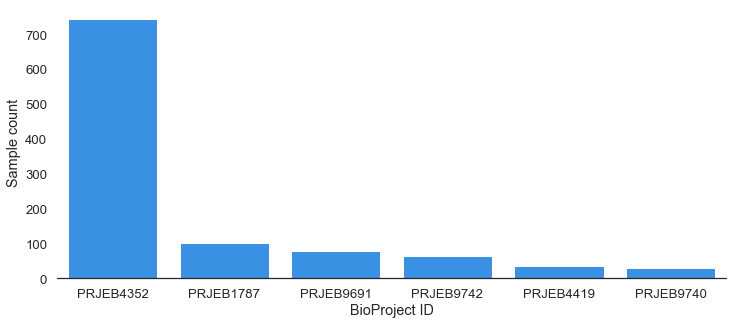

In [14]:
sample_counts = marine_meta_df['Bioproject ID'].value_counts()

sns.set(rc={'figure.figsize':(12, 5), 'font.family': ['Arial']}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    ax = sns.barplot(x=sample_counts.index, y=sample_counts.values, color='dodgerblue')

    ax.set_xlabel('BioProject ID')
    ax.set_ylabel('Sample count')
    
    sns.despine(left=True)

We can also visualize size range for each fraction using the lower and upper limits provided in the metadata table.

In [15]:
replace_dict = {'<': 0, '>': 10000}

fractions = marine_meta_df.loc[:,
    ['Size fraction lower threshold [sample]', 'Size fraction upper threshold [sample]', 'Bioproject ID']
].replace(replace_dict)

for col in ('Size fraction lower threshold [sample]', 'Size fraction upper threshold [sample]'):
    fractions[col] = fractions[col].astype(float)

In [16]:
fractions = fractions \
    .groupby(['Size fraction lower threshold [sample]', 'Size fraction upper threshold [sample]']) \
    .count()['Bioproject ID'] \
    .unstack()

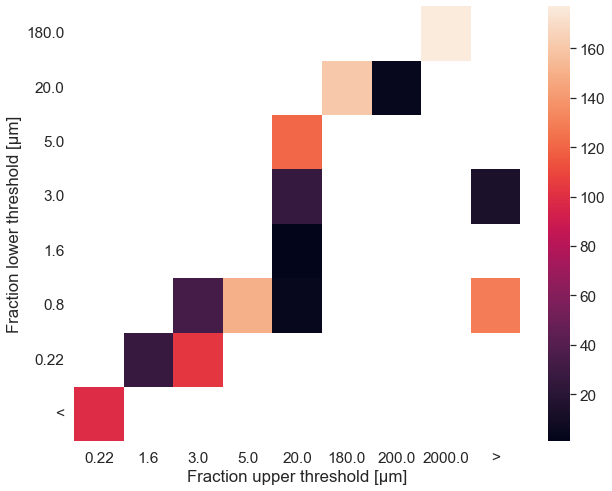

In [17]:
sns.set(rc={'figure.figsize':(10, 8), 'font.family': ['Arial']}, style='white')
with sns.plotting_context("notebook", font_scale=1.4):
    ax = sns.heatmap(data=fractions)

    ax.set_xlabel('Fraction upper threshold [μm]')
    ax.set_ylabel('Fraction lower threshold [μm]')
    
    ax.invert_yaxis()
    
    xlabels = ax.get_xticklabels()
    xlabels[-1] = '>'
    ylabels = ax.get_yticklabels()
    ylabels[0] = '<'
    ax.set_yticklabels(ylabels, rotation=0)
    ax.set_xticklabels(xlabels, rotation=0)

In [18]:
# switch off inline mode to correctly display QIIME 2 visualizations
%matplotlib auto

Using matplotlib backend: <object object at 0x7f3be44447d0>


## Visualize selected metadata using samples' geographic coordinates
We can use the [**q2-coordinates**](https://github.com/bokulich-lab/q2-coordinates) plugin to visualize a variety of sensor values (and other metadata) according to their geographical locations.

In [19]:
n_samples = 100
latitude_col = 'Latitude start [sample]'
longitude_col = 'Longitude start [sample]'

marine_smp = marine_meta_df.sample(n=n_samples, random_state=random_seed)
marine_smp.shape

(100, 74)

### TARA Oceans expedition progress
We will use the sampling date as a categorical variable to display progress of the expedition.

In [20]:
sorted_samples = marine_smp.sort_values(by='Event date/time start [sample]', ascending=False)

progress_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(sorted_samples),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Event date/time start [sample]',
    color_palette='magma'
)
progress_map.save(os.path.join(results_path, 'progress-map.qzv'))
progress_map

<visualization: Visualization uuid: e64ad683-22dc-4fca-afeb-4397a3286b6c>

### Temperature

In [21]:
temp_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(marine_smp),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Temperature [sample]'
)
temp_map.save(os.path.join(results_path, 'temperature-map.qzv'))
temp_map

<visualization: Visualization uuid: 791fe958-68f4-446d-873a-32eccfef65ab>

### Depth

In [22]:
depth_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(marine_smp),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Depth [sample]',
    color_palette='viridis'
)
depth_map.save(os.path.join(results_path, 'depth-map.qzv'))
depth_map

<visualization: Visualization uuid: 6c160108-21ee-4a4b-b71c-da9374911ea1>

### Salinity

In [23]:
salinity_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(marine_smp),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Salinity sensor [sample]'
)
salinity_map.save(os.path.join(results_path, 'salinity-map.qzv'))
salinity_map

<visualization: Visualization uuid: f9f4244f-e30d-457d-a4d5-79fc8cba1a5a>

### Oxygen content

In [24]:
oxygen_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(marine_smp),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Oxygen sensor [sample]',
    color_palette='viridis'
)
oxygen_map.save(os.path.join(results_path, 'oxygen-map.qzv'))
oxygen_map

<visualization: Visualization uuid: c00498d9-8d33-4ec2-8c4f-52c0ccd293e8>

### Nitrate content

In [25]:
nitrate_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(marine_smp),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Nitrate sensor [sample]',
    color_palette='viridis'
)
nitrate_map.save(os.path.join(results_path, 'nitrate-map.qzv'))
nitrate_map

<visualization: Visualization uuid: 6ee81dcc-8e23-4962-9097-bbb64c28462e>

### Chlorophyll content

In [26]:
chlorophyll_map, = coordinates.visualizers.draw_interactive_map(
    metadata=q2.Metadata(marine_smp),
    latitude=latitude_col,
    longitude=longitude_col,
    column='Chlorophyll sensor [sample]',
    color_palette='terrain'
)
chlorophyll_map.save(os.path.join(results_path, 'chlorophyll-map.qzv'))
chlorophyll_map

<visualization: Visualization uuid: 516be888-c809-4368-a901-7b129b211740>

## Fetch a sample of metagenome sequences using q2-fondue
We can now fetch sequences corresponding to some of those 100 samples that we visualized above. We will only focus on samples from two different locations (5 samples per location; 10 samples total) as they correspond to a very large amount of data. We begin by identifying locations that were multiple samples are available.

In [27]:
lat_col, lon_col = 'Latitude end [sample]', 'Longitude end [sample]'

In [28]:
# find all locations with exactly 5 samples
loc_counts = marine_meta_df.groupby([lat_col, lon_col]).count()
loc_counts_multi = loc_counts[loc_counts['Experiment ID'] == 5]
loc_counts_multi.shape

(27, 72)

In [29]:
# draw two locations of the previous list
loc_smp = loc_counts_multi.sample(n=2, random_state=random_seed)
lats = loc_smp.index.get_level_values(lat_col).tolist()
lons = loc_smp.index.get_level_values(lon_col).tolist()

In [30]:
marine_loc_smp = marine_meta_df[
    marine_meta_df[lat_col].isin(lats) & \
    marine_meta_df[lon_col].isin(lons)
]
marine_loc_smp.groupby([lat_col, lon_col]).count().iloc[:, :2]

,,Experiment ID,Biosample ID
Latitude end [sample],Longitude end [sample],,
67.1385,0.2443,5,5
72.4769,-71.9329,5,5


Finally, we are ready to download the actual sequences.

In [31]:
single_reads_out = os.path.join(results_path, 'tara-single.qza')
paired_reads_out = os.path.join(results_path, 'tara-paired.qza')

In [32]:
if not os.path.isfile(paired_reads_out):
    _ids = pd.Series(marine_loc_smp.index.to_list(), name='ID')
    _, paired_reads, _ = fondue.methods.get_sequences(
        accession_ids=q2.Artifact.import_data('NCBIAccessionIDs', _ids), 
        email=email,
        n_jobs=n_jobs
    )
    paired_reads.save(paired_reads_out)
else:
    print(f'Paired-reads artifact exists and will be read from {paired_reads_out}.')
    paired_reads = q2.Artifact.load(paired_reads_out)

Paired-reads artifact exists and will be read from u3-metagenome-results/tara-paired.qza.


## Subsample the reads
We will subsample the reads in every sample to 20% of the original count to reduce the amount of data. The final sample will become an artifact containing only single-end reads that were drawn from both, forward and reverse, reads in the paired-end artifact.

In [ ]:
single_reads_smp_out = os.path.join(results_path, 'single-reads-smp.qza')
if not os.path.isfile(single_reads_smp_out):
    single_reads_smp, = demux.methods.subsample_single(
        sequences=paired_reads,
        fraction=0.2
    )
    single_reads_smp.save(single_reads_smp_out)
else:
    print(f'Subsampled single-reads artifact exists and will be read from {single_reads_smp_out}.')
    single_reads_smp = q2.Artifact.load(single_reads_smp_out)

Subsampled single-reads artifact exists and will be read from u3-metagenome-results/single-reads-smp.qza.


## Calculate and compare MinHash signatures for every metagenome
We will calculate MinHash signatures of every sample (metagenome) using `q2-sourmash`. First, we calculate the hashes from the short reads using the `compute` action. Subsequently, we generate a distance matrix comparing hashes pairwise (using the `compare` action).

In [ ]:
genome_hash_out = os.path.join(results_path, 'genome-hash.qza')
if not os.path.isfile(genome_hash_out):
    genome_hash, = sourmash.methods.compute(
        sequence_file=single_reads_smp,
        ksizes=31,
        scaled=1000
    )
    genome_hash.save(genome_hash_out)
else:
    print(f'Genome hashes artifact exists and will be read from {genome_hash_out}.')
    genome_hash = q2.Artifact.load(genome_hash_out)

In [ ]:
hash_compare_out = os.path.join(results_path, 'hash-compare.qza')
if not os.path.isfile(hash_compare_out):
    hash_compare, = sourmash.methods.compare(
        min_hash_signature=genome_hash,
        ksize=31
    )
    hash_compare.save(hash_compare_out)
else:
    print(f'Distance matrix artifact exists and will be read from {hash_compare_out}.')
    hash_compare = q2.Artifact.load(hash_compare_out)

## Perform dimensionality reduction of the metagenome MinHash distance matrix
Finally, a 2D PCoA plot is generated from the obtained distance matrix (`pcoa` method from the `q2-diversity` plugin) and visualized using the EMPeror plot (`plot` action from the `q2-emperor` plugin).

In [ ]:
genome_pcoa, = diversity.methods.pcoa(
    distance_matrix=hash_compare,
)

In [ ]:
emperor_plot_out = os.path.join(results_path, 'emperor-plot.qzv')
if not os.path.isfile(emperor_plot_out):
    emperor_plot, = emperor.visualizers.plot(
        pcoa=genome_pcoa,
        metadata=q2.Metadata(marine_loc_smp)
    )
    emperor_plot.save(emperor_plot_out)
else:
    print(f'Emperor plot artifact exists and will be read from {emperor_plot_out}.')
    emperor_plot = q2.Visualization.load(emperor_plot_out)

In [ ]:
emperor_plot

We can also use the results above to generate our own plots using any of the Python plotting libraries - see below.

In [ ]:
pcoa_table = genome_pcoa.view(skbio.OrdinationResults)
pcoa_df = pcoa_table.samples

In [ ]:
# switch to inline plotting
%matplotlib inline

In [ ]:
# create a 2D plot of Dim1 vs Dim2

sns.set(rc={'figure.figsize':(8, 8), 'font.family': ['Arial']}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlabel(f'Axis 1 ({round(100 * pcoa_table.proportion_explained[0], 2)}%)')
    ax.set_ylabel(f'Axis 2 ({round(100 * pcoa_table.proportion_explained[1], 2)}%)')
    
    sns.scatterplot(
        x=pcoa_df.iloc[:, 0],
        y=pcoa_df.iloc[:, 1],
        s=200,
        hue=marine_loc_smp['Latitude end [sample]'],
        palette='Dark2',
        ax=ax,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(results_path, 'tara_pcoa.eps'))

We can see in the plots above that the samples obtained in the two analyzed locations can be separated into distinct groups using only their MinHash signatures.